# Research Hub Operational Data Insights

Putting Prometheus and Grafana on the research hubs' kubernetes clusters was a great idea as it allowed me to see some easy visualizations for cluster health. There is also the benefit of being able to export data from Grafana dashboards to analyze in Pandas. However, since we haven't configured a different data storage option for Prometheus, we only have about 11 days of data (unless I grab data 11 days apart).

The two research hubs are https://aws-uswest2.pangeo.io/ and https://us-central1-b.gcp.pangeo.io/hub/login they will be generally referred to as 'AWS' and 'GCP'.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

sns.set(style="darkgrid")

%matplotlib inline

## Data Wrangling

In [2]:
aws_mem_csv_files = ["data/aws-hub-memory-data-oct-16.csv",
                     "data/aws-hub-memory-data-oct-18.csv",
                     "data/aws-hub-memory-data-oct-20.csv"]
aws_cpu_csv_files = ["data/aws-hub-cpu-data-oct-16.csv", 
                     "data/aws-hub-cpu-data-oct-18.csv",
                     "data/aws-hub-cpu-data-oct-20.csv"]
gcp_mem_csv_files = ["data/gcp-hub-memory-data-oct-16.csv", 
                     "data/gcp-hub-memory-data-oct-18.csv", 
                     "data/gcp-hub-memory-data-oct-20.csv"]
gcp_cpu_csv_files = ["data/gcp-hub-cpu-data-oct-16.csv", 
                     "data/gcp-hub-cpu-data-oct-18.csv", 
                     "data/gcp-hub-cpu-data-oct-20.csv"]

### Concatenate Multiple Data Files (if needed)

Grafana data has only held some static amount of data, meaning that we do not get to look through data from when the deployment was originally set up. Currently, the AWS hub appears to hold about 11 days of data and the GCP hub holds just under 2. Because of this, we need to collect multiple data files and concatenate them together for a most holistic view of performance.

What I want is a time-indexed dataframe with two columns: the memory usage and the pod name using that memory.

The following function ingests and cleans the grafana data. I can use it for each of the four data files I have.

In [3]:
def get_pod_data_two_cols(filenames, value_col_name):
    """
    Imports and concatenates many filename.csv to a Pandas dataframe
    Sets the index as 'Time'
    Drops the columns 'quota - requests', 'quota - limits'
    Drops duplicate rows in case of overlap
    Makes many dataframes of the index and another column
    Adds a column as the name of the pod
    Renames the original column to value_col_name
    Drops nan values from dataframes
    Concatenates these dataframes to one dataframe and returns it
    """
    
    df = pd.concat([pd.read_csv(filename,
                                index_col=0,
                                parse_dates=True,
                                infer_datetime_format=True) for filename in filenames])
    df = df.drop(columns=["quota - requests", "quota - limits"])
    df = df.drop_duplicates()
    df = pd.concat([pd.DataFrame(data={value_col_name: df[col],
                                       'pod_name': col}).dropna() for col in df.columns.values])
    df = df.sort_index()
    
    return df

In [4]:
aws_mem_df = get_pod_data_two_cols(aws_mem_csv_files, 'memory')
aws_cpu_df = get_pod_data_two_cols(aws_cpu_csv_files, 'cpu')
gcp_mem_df = get_pod_data_two_cols(gcp_mem_csv_files, 'memory')
gcp_cpu_df = get_pod_data_two_cols(gcp_cpu_csv_files, 'cpu')

I actually also want data that is the normal format that Grafana exports it in. Summations over all pods is much easier in this format.

In [5]:
def get_pod_data_many_cols(filenames):
    """
    Imports filename.csv to a Pandas dataframe
    Sets the index as 'Time'
    Drops the columns 'quota - requests', 'quota - limits'
    Drops rows with no data
    """
    
    df = pd.concat([pd.read_csv(filename,
                                index_col=0,
                                parse_dates=True,
                                infer_datetime_format=True) for filename in filenames])
    df = df.drop(columns=["quota - requests", "quota - limits"])
    df = df.drop_duplicates()
    df = df.dropna(axis="index", how="all")
    df = df.sort_index()
    
    return df

In [6]:
aws_many_mem_df = get_pod_data_many_cols(aws_mem_csv_files)
aws_many_cpu_df = get_pod_data_many_cols(aws_cpu_csv_files)
gcp_many_mem_df = get_pod_data_many_cols(gcp_mem_csv_files)
gcp_many_cpu_df = get_pod_data_many_cols(gcp_cpu_csv_files)

Change memory data from bytes to GB

In [7]:
aws_mem_df.loc[:, "memory"] /= (1024*1024*1024)
gcp_mem_df.loc[:, "memory"] /= (1024*1024*1024)

In [8]:
aws_mem_df.head()

,memory,pod_name
Time,,
2020-10-06 05:20:00,0.095673,api-icesat2-prod-dask-gateway-798c9798f8-bpwcf
2020-10-06 05:20:00,0.110100,controller-icesat2-prod-dask-gateway-78f86f6f6...
2020-10-06 05:20:00,0.217659,hub-5c554bb6b5-qvjnm
2020-10-06 05:20:00,0.193489,icesat2-prod-ingress-nginx-controller-69b6d479...
2020-10-06 05:20:00,0.024063,icesat2-prod-kube-state-metrics-75bfcfbd8c-scd9j


In [9]:
aws_many_mem_df /= (1024*1024*1024)
gcp_many_mem_df /= (1024*1024*1024)

In [10]:
aws_many_mem_df.tail()

,api-icesat2-prod-dask-gateway-798c9798f8-bpwcf,autohttps-6c669c845d-5ld64,controller-icesat2-prod-dask-gateway-78f86f6f6d-f4nxg,dask-scheduler-04c170d2a43845b1b3615a30e1f14ae6,dask-scheduler-2d75a3c022794e0ca895c8cfbf756a87,dask-scheduler-3efefa2916d041728ffae1591d540734,dask-scheduler-410bb88f732e4680b5456aeb85881f9a,dask-scheduler-411048210dae490dbbf6f8f1c74ab77e,dask-scheduler-489fe79f6bf7448ea2c022a62751a31f,dask-scheduler-4b52a76a35694213a981d9cb3c26b6a7,...,dask-worker-fd83a73a6d114d768f7c6d1c5bab6782-d5w88,dask-worker-fd83a73a6d114d768f7c6d1c5bab6782-f7hpd,dask-worker-fd83a73a6d114d768f7c6d1c5bab6782-grp9b,dask-worker-fd83a73a6d114d768f7c6d1c5bab6782-jbdxx,dask-worker-fd83a73a6d114d768f7c6d1c5bab6782-mclxc,dask-worker-fd83a73a6d114d768f7c6d1c5bab6782-nphdl,dask-worker-fd83a73a6d114d768f7c6d1c5bab6782-pkltj,dask-worker-fd83a73a6d114d768f7c6d1c5bab6782-v2lfp,dask-worker-fd83a73a6d114d768f7c6d1c5bab6782-vw4p2,dask-worker-fd83a73a6d114d768f7c6d1c5bab6782-xs89q
Time,,,,,,,,,,,,,,,,,,,,,
2020-10-20 13:30:00,0.098747,0.124924,0.122177,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-10-20 13:35:00,0.098747,0.124924,0.122177,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-10-20 13:40:00,0.098747,0.124924,0.122177,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-10-20 13:45:00,0.098747,0.124924,0.122177,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-10-20 13:50:00,0.098747,0.124924,0.122177,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Find time ranges for each dataset

GCP data has a much smaller time range. I'm guessing this is because there is more data per unit time.

In [11]:
def get_time_bounds(df, index_label):
    """
    Finds the minimum and maximum times of a dataframe with a datetime64 index
    """
    
    earliest_time = df.sort_index().index.drop_duplicates().values[0]
    latest_time = df.sort_index().index.drop_duplicates().values[-1]
    second_time = df.sort_index().index.drop_duplicates().values[1]
    
    return pd.DataFrame({"Earliest Date": earliest_time,
                         "Latest Date": latest_time,
                         "Time Range Covered": latest_time - earliest_time,
                         "Time Step Width": second_time - earliest_time},
                        index=[index_label])

In [12]:
pd.concat([get_time_bounds(aws_mem_df, "AWS Memory Data"),
           get_time_bounds(aws_cpu_df, "AWS CPU Data"),
           get_time_bounds(gcp_mem_df, "GCP Memory Data"),
           get_time_bounds(gcp_cpu_df, "GCP CPU Data")])

,Earliest Date,Latest Date,Time Range Covered,Time Step Width
AWS Memory Data,2020-10-06 05:20:00,2020-10-20 13:50:00,14 days 08:30:00,0 days 00:20:00
AWS CPU Data,2020-10-06 05:20:00,2020-10-20 13:50:00,14 days 08:30:00,0 days 00:20:00
GCP Memory Data,2020-10-14 19:56:00,2020-10-20 13:40:00,5 days 17:44:00,0 days 00:04:00
GCP CPU Data,2020-10-14 19:55:00,2020-10-20 12:20:00,5 days 16:25:00,0 days 00:01:00


## Plotting

Desired plots:
- Number of users each hour, day, hub
  - Can try this with memory and cpu data to see if they differ
- Total CPU used each hour, day, hub
- Total memory used each hour, day, hub
  - Split these for the following pod types
    - hub
    - user
    - dask?
    
This will require some additional features; I want to split pods into categories.
- dask
- users
- everything else (hub)

In [13]:
def set_pod_types(df):
    """
    Sets pod types for a dataframe
    Pod names with 'jupyter' are set as 'user'
    Pod names with 'dask' are set as 'dask'
    All other pod names are set as 'hub'
    """
    
    df.loc[df.pod_name.str.contains("jupyter"), "pod_type"] = "user"
    df.loc[df.pod_name.str.contains("dask"), "pod_type"] = "dask"
    df = df.fillna("hub")
    return df

In [14]:
aws_mem_df = set_pod_types(aws_mem_df)
aws_cpu_df = set_pod_types(aws_cpu_df)
gcp_mem_df = set_pod_types(gcp_mem_df)
gcp_cpu_df = set_pod_types(gcp_cpu_df)

### Unique Hub Users

In [15]:
def print_unique_users(df, label):
    """
    Prints the unique number of users in a dataframe
    """
    
    print("Unique Users in %s: %d" % (label, df[df.pod_type == "user"].pod_name.nunique()))

In [16]:
print_unique_users(aws_mem_df, "AWS Memory Data")
print_unique_users(aws_cpu_df, "AWS CPU Data")
print_unique_users(gcp_mem_df, "GCP Memory Data")
print_unique_users(gcp_cpu_df, "GCP CPU Data")

Unique Users in AWS Memory Data: 10
Unique Users in AWS CPU Data: 10
Unique Users in GCP Memory Data: 14
Unique Users in GCP CPU Data: 18


### Hub Users per Hour

memory and cpu data agree

GCP Data would be more useful if we had a greater time range.

NOTE: I need to revisit how the cpu and memory values are calculated in Grafana. I recall one of them is be a current value and another is the average. I may need to do a sum on one and an average on the other.

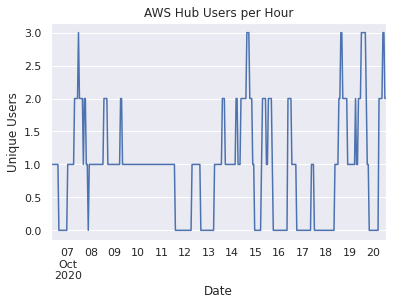

In [17]:
_ = aws_mem_df[aws_mem_df.pod_type == "user"].resample("1H").nunique()["pod_name"].plot()
_ = plt.ylabel("Unique Users")
_ = plt.xlabel("Date")
_ = plt.title("AWS Hub Users per Hour")

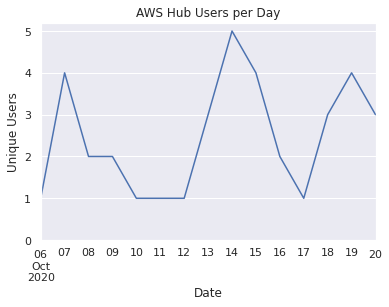

In [18]:
_ = aws_mem_df[aws_mem_df.pod_type == "user"].resample("1D").nunique()["pod_name"].plot()
_ = plt.ylim(bottom=0)
_ = plt.ylabel("Unique Users")
_ = plt.xlabel("Date")
_ = plt.title("AWS Hub Users per Day")
plt.savefig("plots/aws-users-per-day.png")

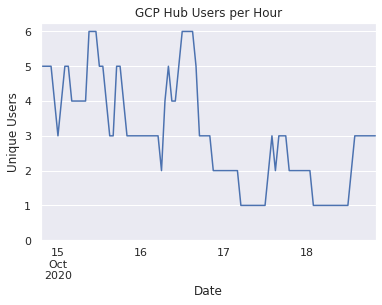

In [19]:
_ = gcp_mem_df[gcp_mem_df.pod_type == "user"].resample("1H").nunique()["pod_name"].plot()
_ = plt.ylim(bottom=0)
_ = plt.ylabel("Unique Users")
_ = plt.xlabel("Date")
_ = plt.title("GCP Hub Users per Hour")

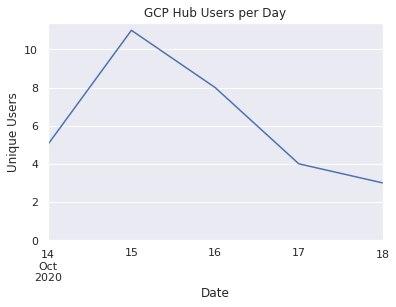

In [20]:
_ = gcp_mem_df[gcp_mem_df.pod_type == "user"].resample("1D").nunique()["pod_name"].plot()
_ = plt.ylim(bottom=0)
_ = plt.ylabel("Unique Users")
_ = plt.xlabel("Date")
_ = plt.title("GCP Hub Users per Day")
plt.savefig("plots/gcp-users-per-day.png")

Plot some of these over each other?

It might look rather jarring, GCP data will be very compressed in x but dominate the plot in y.

### Overall Resource Usage

This can probably be removed in favor of the function below.

In [21]:
def plot_total_values(df, total_col_name, by_col):
    """
    Sum the data across the row (timestamp) to get total cpu / memory usage for that period
    This will modify the input dataframe
    Optional: Separate sums based on by_col
    Plot this quantity
    """
    
    #plot_df = df.reset_index().groupby(["Time", "pod_name"]).mean().unstack(level=1)
    df.loc[:, total_col_name] = [df.iloc[row, :].sum() for row in range(len(df))]
    
    #if by_col:
    
    _ = df.plot(y=total_col_name)
    _ = plt.xlabel("Date")

    if (plt.ylim()[0] > 0):
        _ = plt.ylim(bottom=0)
    
    return _

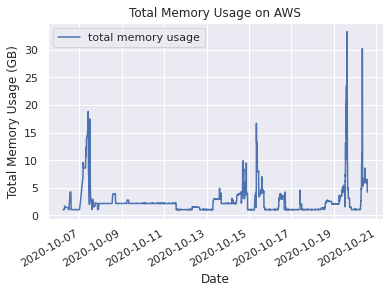

In [22]:
_ = plot_total_values(aws_many_mem_df, "total memory usage", None)
_ = plt.ylabel("Total Memory Usage (GB)")
_ = plt.title("Total Memory Usage on AWS")

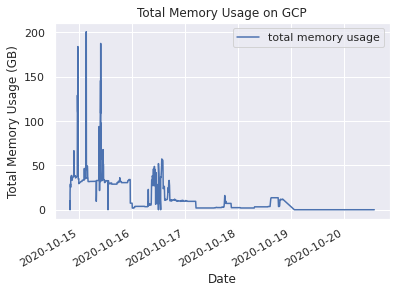

In [23]:
_ = plot_total_values(gcp_many_mem_df, "total memory usage", None)
_ = plt.ylabel("Total Memory Usage (GB)")
_ = plt.title("Total Memory Usage on GCP")

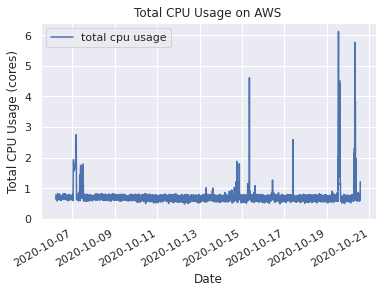

In [24]:
_ = plot_total_values(aws_many_cpu_df, "total cpu usage", None)
_ = plt.ylabel("Total CPU Usage (cores)")
_ = plt.title("Total CPU Usage on AWS")

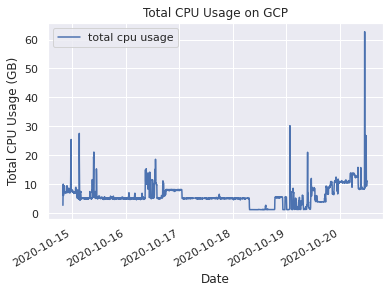

In [25]:
_ = plot_total_values(gcp_many_cpu_df, "total cpu usage", None)
_ = plt.ylabel("Total CPU Usage (GB)")
_ = plt.title("Total CPU Usage on GCP")

### Resource Usage by Pod Type

In [26]:
def plot_usage_breakdown(df, total_col_name, group_names=None, metric=None):
    """
    Get the data with the original .csv file format, one column for each pod
    Sum the data across the row (timestamp) to get total cpu / memory usage for that period
    Optional:
      Provide the group names (pod_types) and the metric (memory, cpu)
      Build new column names and manually filters on the three configured pod types to create partial sums
    Plot the total. Plot the sums if group_names and metric are specified
    """
    
    # Set up figure
    #fig, ax = plt.subplots()
    
    # Set up basic total col
    df.loc[:, total_col_name] = [df.iloc[row, ~(df.columns.str.contains("total"))].sum() for row in range(len(df))]
    
    if metric and group_names:
    
        # Set up column names
        group_col_names = ["total %s for %s pods" % (metric, name) for name in group_names]
    
        # Create sums for the three pod_types: user, dask, hub
        # Need to filter out 'total' columns to not be counted in the hub total
        df.loc[:, group_col_names[0]] = df.loc[:, (df.columns.str.contains("jupyter")) &
                                                  ~(df.columns.str.contains("total"))].sum(axis=1)
        df.loc[:, group_col_names[1]] = df.loc[:, (df.columns.str.contains("dask")) &
                                                  ~(df.columns.str.contains("total"))].sum(axis=1)
        df.loc[:, group_col_names[2]] = df.loc[:, ~(df.columns.str.contains("jupyter")) &
                                                  ~(df.columns.str.contains("dask")) &
                                                  ~(df.columns.str.contains("total"))].sum(axis=1)
    
    # Trim down columns for plotting
    plot_df = df.loc[:, (df.columns.str.contains("total")) &
                        (df.columns.str.contains(metric))]
    _ = plot_df.plot()
    _ = plt.xlabel("Date")
    
    if (plt.ylim()[0] > 0):
        _ = plt.ylim(bottom=0)
        
    return _

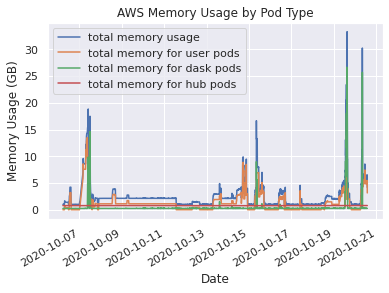

In [27]:
_ = plot_usage_breakdown(aws_many_mem_df, "total memory usage", ["user", "dask", "hub"], "memory")
_ = plt.ylabel("Memory Usage (GB)")
_ = plt.title("AWS Memory Usage by Pod Type")
plt.savefig("plots/aws-memory-usage.png")

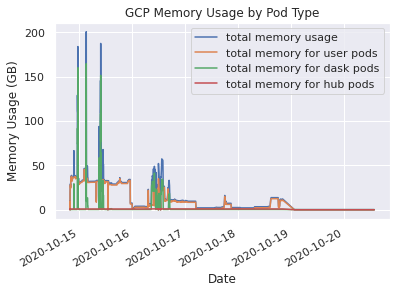

In [28]:
_ = plot_usage_breakdown(gcp_many_mem_df, "total memory usage", ["user", "dask", "hub"], "memory")
_ = plt.ylabel("Memory Usage (GB)")
_ = plt.title("GCP Memory Usage by Pod Type")
plt.savefig("plots/gcp-memory-usage.png")

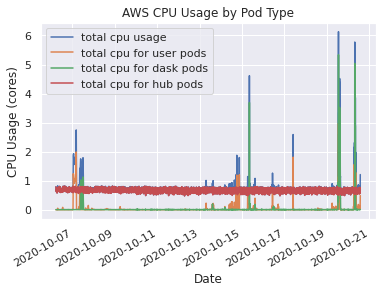

In [29]:
_ = plot_usage_breakdown(aws_many_cpu_df, "total cpu usage", ["user", "dask", "hub"], "cpu")
_ = plt.ylabel("CPU Usage (cores)")
_ = plt.title("AWS CPU Usage by Pod Type")
plt.savefig("plots/aws-cpu-usage.png")

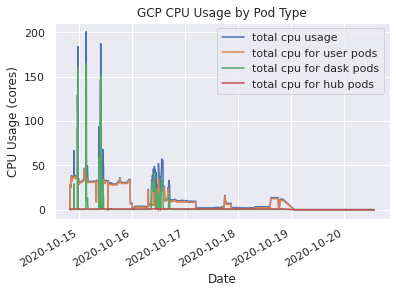

In [30]:
_ = plot_usage_breakdown(gcp_many_mem_df, "total cpu usage", ["user", "dask", "hub"], "cpu")
_ = plt.ylabel("CPU Usage (cores)")
_ = plt.title("GCP CPU Usage by Pod Type")
plt.savefig("plots/gcp-cpu-usage.png")

### User Session Duration

For a jupyter user, find out how long they stay on the hub.

Use the many_mem or many_cpu dataframes, where a user will have a column to themselves. Aggregate all of the measurements (how many timesteps / session duration), then histogram it.

This will require data with a timestep of 5 or 10 minutes, which will require manual creation.

The oct 20th data has fulfills this requirement (5 min timesteps).

In [31]:
import datetime

five_min = datetime.timedelta(minutes=5)

In [32]:
def get_user_session_data(filenames):
    """
    Imports filename.csv to a Pandas dataframe
    Make sure index has no holes
    Sets the index as 'Time'
    Keeps only columns that contain 'jupyter'
    Drops rows with no data
    """
    
    df = pd.concat([pd.read_csv(filename,
                                index_col=0,
                                parse_dates=True,
                                infer_datetime_format=True) for filename in filenames])
    
    df = df.loc[:, df.columns.str.contains("jupyter")]
    df = df.drop_duplicates()
    df = df.sort_index()
    
    # Make a new date range for the index
    date_range = pd.date_range(df.index[0], df.index[-1], freq="5min")
    df = pd.DataFrame(data=df, index=date_range)
    
    return df

In [33]:
aws_user_session_data = get_user_session_data(["data/aws-hub-cpu-data-oct-20.csv"])
aws_user_session_data.head()

,jupyter-ajijohn,jupyter-cspencerjones,jupyter-jessicas11,jupyter-robfatland,jupyter-rsignell-2dusgs,jupyter-salvis2,jupyter-scottyhq,jupyter-tomaugspurger
2020-10-09 13:50:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-10-09 13:55:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-10-09 14:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-10-09 14:05:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-10-09 14:10:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


All the entries are five minutes apart

In [34]:
pd.Series([aws_user_session_data.index[time+1] -
           aws_user_session_data.index[time] for time in range(len(aws_user_session_data.index) - 1)]).sort_values().value_counts()

0 days 00:05:00    3168
dtype: int64

In [35]:
gcp_user_session_data = get_user_session_data(["data/gcp-hub-cpu-data-oct-20.csv"])
gcp_user_session_data.head()

,jupyter-aaronspring,jupyter-alatreille,jupyter-andrewbrettin,jupyter-auraoupa,jupyter-cgentemann,jupyter-cspencerjones,jupyter-dhruvbalwada,jupyter-jakesteinberg,jupyter-jbusecke,jupyter-lufiedl,jupyter-mikebyrne6,jupyter-qyxiao,jupyter-rabernat,jupyter-sashamontelli,jupyter-sckw,jupyter-scottyhq,jupyter-shunzlu,jupyter-stb2145
2020-10-14 12:20:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-10-14 12:25:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-10-14 12:30:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-10-14 12:35:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-10-14 12:40:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [36]:
pd.Series([gcp_user_session_data.index[time+1] -
           gcp_user_session_data.index[time] for time in range(len(gcp_user_session_data.index) - 1)]).sort_values().value_counts()

0 days 00:05:00    1728
dtype: int64

In [37]:
pd.concat([get_time_bounds(aws_user_session_data, "AWS User Session Data"),
           get_time_bounds(gcp_user_session_data, "GCP User Session Data")])

,Earliest Date,Latest Date,Time Range Covered,Time Step Width
AWS User Session Data,2020-10-09 13:50:00,2020-10-20 13:50:00,11 days,0 days 00:05:00
GCP User Session Data,2020-10-14 12:20:00,2020-10-20 12:20:00,6 days,0 days 00:05:00


### Calculate User Session Durations



In [38]:
def calculate_session_durations(df, user_str):
    """
    For all users in a dataframe, calculate their session durations
    Columns will be qualified as 'users' if they have 'user_str' in them
    Then, we will find the start and end timestamps for each user and calculate each sessions' duration
    """
    
    # Setup
    session_durations = []
    users = df.loc[:, df.columns.str.contains(user_str)].columns.values
    
    for user in users:
    
        start_times = find_start_times(df, user)
        end_times = find_end_times(df, user)
    
        assert len(start_times) == len(end_times)
    
        # Add five minutes because this is the timestep
        session_durations += [end_times[idx] - start_times[idx] + five_min for idx in range(len(start_times))]
    
    return session_durations

def find_start_times(df, user):
    """
    Find indices where data begins
    These are either index 0, if there is data there
    Or any index with a value if the previous index does not have a value
    """
    
    start_times = [time for time in df.index 
                        if ((time == df.index[0] and df.notna().loc[time, user]) or
                             (time != df.index[0] and df.isna().loc[time - five_min, user] and df.notna().loc[time, user]))]
    return start_times

def find_end_times(df, user):
    """
    Find indices where data ends
    There are either index len(df) - 1, if there is data there
    Or any index with a value if the next index does not have a value
    """
    
    end_times = [time for time in df.index 
                      if ((time == df.index[-1] and df.notna().loc[time, user]) or
                          (time != df.index[-1] and df.isna().loc[time + five_min, user] and df.notna().loc[time, user]))]
    
    return end_times

### AWS Hub User Sessions

In [39]:
session_durations = calculate_session_durations(aws_user_session_data, "jupyter")
session_durations_minutes = [dur.total_seconds()/60 for dur in session_durations]
session_durations_minutes.sort()

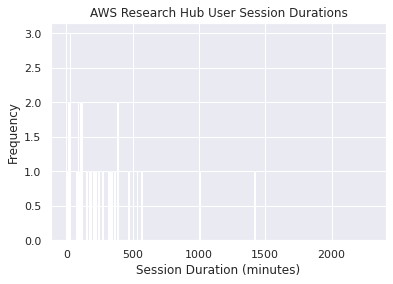

In [40]:
_ = plt.hist(session_durations_minutes,
             bins=range(0, int(session_durations_minutes[-1]), 5),
             color='b')
_ = plt.ylabel("Frequency")
_ = plt.xlabel("Session Duration (minutes)")
_ = plt.title("AWS Research Hub User Session Durations")
#_ = plt.xscale("log")

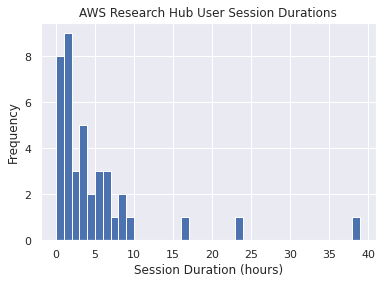

In [41]:
aws_session_durations_hours = [dur/60 for dur in session_durations_minutes]
_ = plt.hist(aws_session_durations_hours,
             bins=range(0, 40, 1),
             color='b')
_ = plt.ylabel("Frequency")
_ = plt.xlabel("Session Duration (hours)")
_ = plt.title("AWS Research Hub User Session Durations")
plt.savefig("plots/aws-users-session-durations.png")

### GCP Hub User Sessions

In [42]:
gcp_session_durations = calculate_session_durations(gcp_user_session_data, "jupyter")
gcp_session_durations = [dur.total_seconds()/60/60 for dur in gcp_session_durations]
gcp_session_durations.sort()

There is an outlier at ~136 hours, I don't want to visualize that.

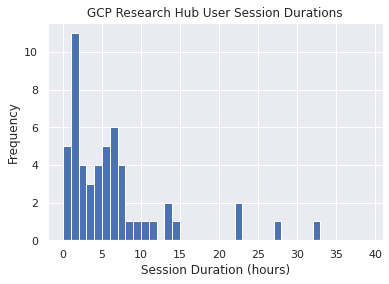

In [43]:
_ = plt.hist(gcp_session_durations,
             bins=range(0, 40, 1))
_ = plt.ylabel("Frequency")
_ = plt.xlabel("Session Duration (hours)")
_ = plt.title("GCP Research Hub User Session Durations")
plt.savefig("plots/gcp-users-session-durations.png")